###  Created by Luis Alejandro (alejand@umich.edu)

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from utils import unicode_to_ascii
from dataset import DatasetBuilder
from attention_translation import preprocess
from attention_translation import Translator
import os
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"]="true"

In [2]:
# GPU?
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
def plot_attention(attention, source, target, builder):
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')
    ax.set_xticklabels([''] + [builder.source_tokenizer.index_to_word[word].decode() for word in source], rotation=90)
    ax.set_yticklabels([''] + [builder.target_tokenizer.index_to_word[word].decode() for word in target])
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    plt.show()

In [4]:
# Creates dataset for training
files = ['../../datasets/nlp/english-spanish.txt']
builder = DatasetBuilder(files, preprocessors=(preprocess,preprocess), batch_size=64, max_obs=30000, test_obs=40)
train_dataset, test_dataset = builder.build()

In [5]:
# Load embedding matrix (glove vectors) -> these will only be used for English (source/input)
embedding_size = 100
word_to_vector = {}
with open('../../datasets/glove.6B/glove.6B.%sd.txt' % embedding_size, encoding='utf8') as file:
    for line in file:
        values = line.split()
        word = unicode_to_ascii(values[0])
        vector = np.asarray(values[1:],dtype=np.float32)
        word_to_vector[word] = vector
        
embedding_vectors = np.zeros((len(builder.source_tokenizer.word_to_index), embedding_size))
for word, index in builder.source_tokenizer.word_to_index.items():
    if word.decode() in word_to_vector:
        embedding_vectors[index,:] = word_to_vector[word.decode()]

In [11]:
# Defining model
translator = Translator(builder.source_tokenizer.word_to_index,
                        builder.target_tokenizer.word_to_index,
                        source_embedding_matrix=embedding_vectors,
                        target_embedding_size=embedding_size,
                        max_output_length=builder.target_tokenizer.max_seq,
                        attention_size=512,
                        restore=True)

In [12]:
# Training model
translator.train(10, train_dataset, test_dataset)

Epoch 1 out of 10 complete (59.27 secs) -- Train Loss: 0.5349 -- Train Acc: 0.89 -- Test Loss: 0.6156 -- Test Acc: 0.91
Epoch 2 out of 10 complete (26.90 secs) -- Train Loss: 0.4693 -- Train Acc: 0.90 -- Test Loss: 0.5842 -- Test Acc: 0.92
Epoch 3 out of 10 complete (27.10 secs) -- Train Loss: 0.4110 -- Train Acc: 0.91 -- Test Loss: 0.5615 -- Test Acc: 0.92
Epoch 4 out of 10 complete (27.52 secs) -- Train Loss: 0.3602 -- Train Acc: 0.92 -- Test Loss: 0.5512 -- Test Acc: 0.92
Epoch 5 out of 10 complete (27.28 secs) -- Train Loss: 0.3165 -- Train Acc: 0.93 -- Test Loss: 0.5325 -- Test Acc: 0.92
Epoch 6 out of 10 complete (28.05 secs) -- Train Loss: 0.2804 -- Train Acc: 0.93 -- Test Loss: 0.5375 -- Test Acc: 0.93
Epoch 7 out of 10 complete (29.83 secs) -- Train Loss: 0.2497 -- Train Acc: 0.94 -- Test Loss: 0.5249 -- Test Acc: 0.93
Epoch 8 out of 10 complete (28.22 secs) -- Train Loss: 0.2243 -- Train Acc: 0.95 -- Test Loss: 0.5295 -- Test Acc: 0.93
Epoch 9 out of 10 complete (28.74 secs) 

In [13]:
# Creating some input
source = b"I'm very happy to see you."
source = preprocess(tf.constant(source))
source = tf.strings.split(tf.constant(source))
print(source)
source = builder.source_tokenizer.encode(source.numpy())
source = tf.constant(np.pad(source, (0, builder.source_tokenizer.max_seq - len(source))),
                     shape=[1, builder.source_tokenizer.max_seq])
print(source)

tf.Tensor([b'<start>' b'i' b'm' b'very' b'happy' b'to' b'see' b'you' b'.' b'<end>'], shape=(10,), dtype=string)
tf.Tensor([[  0  17  49 946 295 255 104 105   2   3   0]], shape=(1, 11), dtype=int32)


estoy contento de verte . <end>


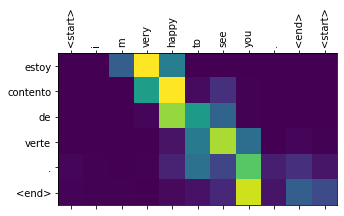

In [14]:
# Outputing model translation
prediction, attention = translator.translate(source, return_attention=True)
print(' '.join(builder.target_tokenizer.index_to_word[word].decode() for word in prediction))
plot_attention(attention, tf.squeeze(source).numpy(), prediction, builder)

Expected: llamen a seguridad !
Translation: llama a seguridad !


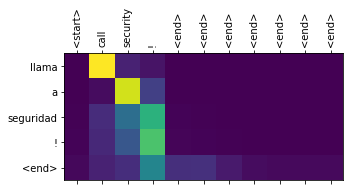

Expected: miralo .
Translation: mira eso .


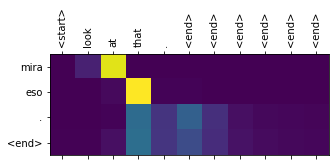

Expected: no estamos locos .
Translation: no estamos locas .


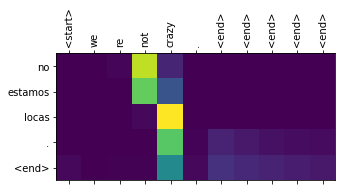

Expected: soy todo oidos .
Translation: soy todo oidos .


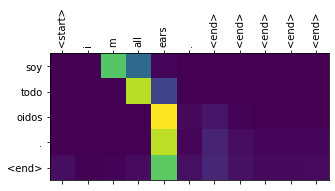

Expected: es solo un gato .
Translation: es solo una cancion .


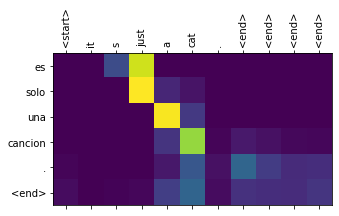

Expected: ¿ alguien esta lastimado ?
Translation: ¿ se lastimo alguien ?


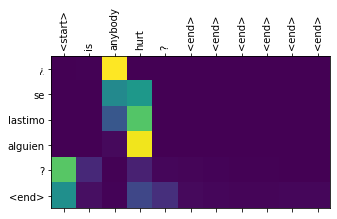

Expected: quemad el cuerpo .
Translation: quemen el cuerpo .


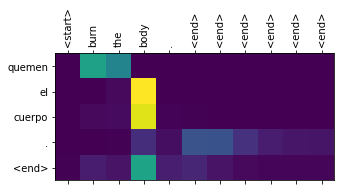

Expected: ella lo extrana .
Translation: ella le pateo .


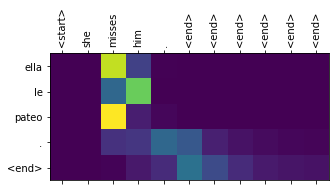

Expected: ellos estaban ocupados .
Translation: ellos estaban ocupados .


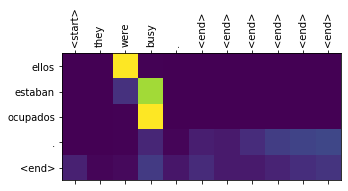

Expected: ¿ que es tu trabajo ?
Translation: ¿ que opina tu trabajo ?


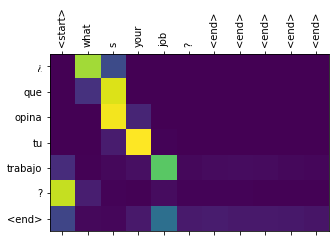

Expected: tom esta temblando .
Translation: tom esta quejando .


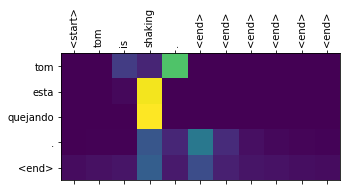

Expected: me encantan los gatos .
Translation: me gustan los gatos .


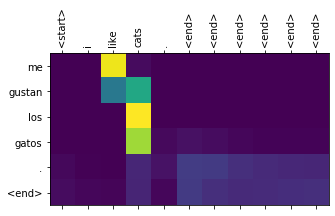

Expected: el vio a la muchacha .
Translation: el vio a la chica .


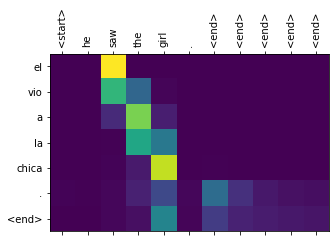

Expected: estas borracha .
Translation: estas borracho .


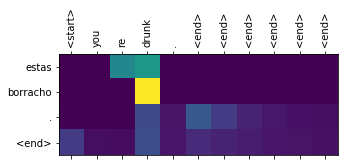

Expected: que imbecil !
Translation: que pendejo !


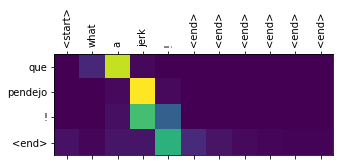

Expected: que agobio .
Translation: esta sofocante .


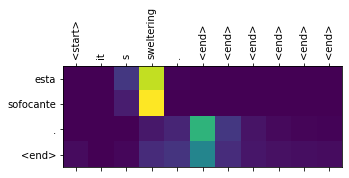

Expected: me pidieron mi identificacion .
Translation: me pidieron identificarme .


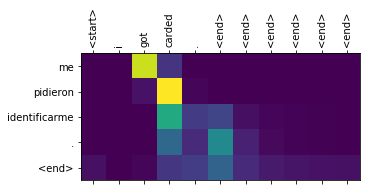

Expected: caminare .
Translation: andare .


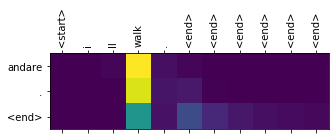

Expected: amo a mi hijo .
Translation: amo a mi hijo .


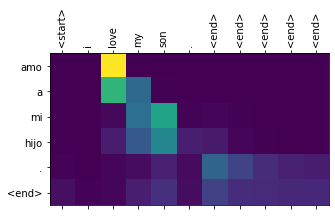

Expected: yo finalmente gane .
Translation: finalmente gane .


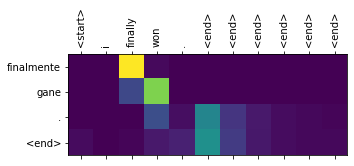

Expected: tom parece borracho .
Translation: tom parece borracho .


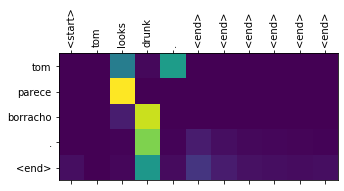

Expected: tom es un cyborg .
Translation: tom es un fascista .


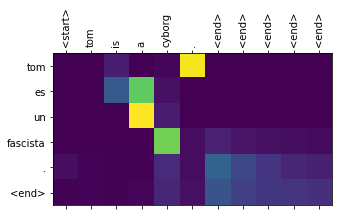

Expected: estoy impaciente .
Translation: soy impaciente .


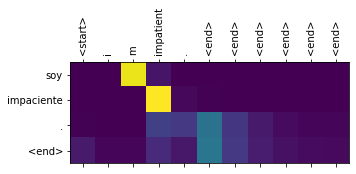

Expected: ¿ subes ?
Translation: ¿ vendras ?


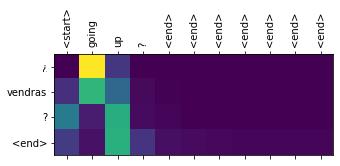

Expected: me encantan los perros .
Translation: me encantan los perros .


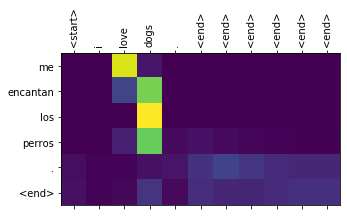

Expected: este es mi vino .
Translation: este es mi vino .


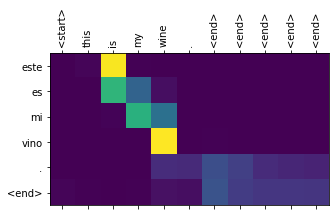

Expected: no soy un heroe .
Translation: no soy un heroe .


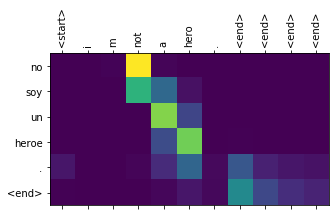

Expected: hablame !
Translation: habla conmigo !


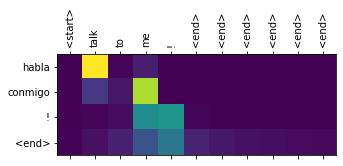

Expected: no veas la television .
Translation: no miremos television .


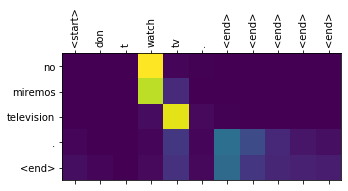

Expected: traere vino .
Translation: voy a cocinar vino .


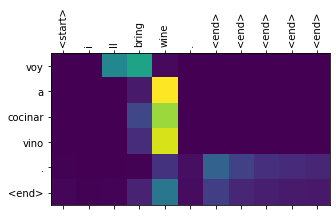

Expected: yo no estaba alli .
Translation: no estaba ahi .


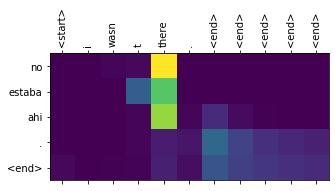

Expected: ¿ estas muerto ?
Translation: ¿ estas muerto ?


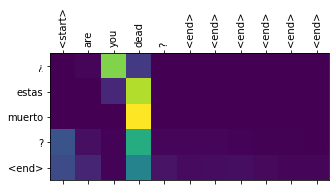

Expected: revisalo de nuevo .
Translation: compruebalo otra vez .


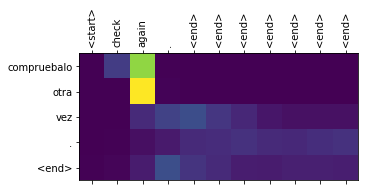

Expected: dejame salir !
Translation: dejadme salir !


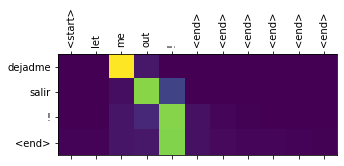

Expected: dejelo a tomas .
Translation: dejalo a tom .


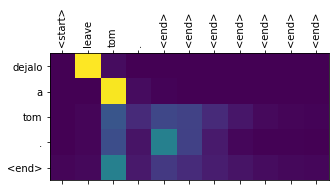

Expected: tenemos un perro .
Translation: tenemos un perro .


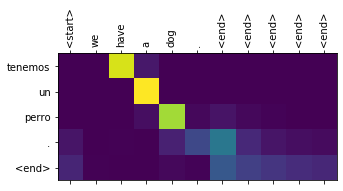

Expected: podemos probarlo .
Translation: podemos probar .


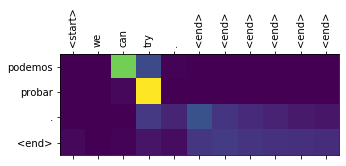

Expected: tom es un maniaco .
Translation: tom es un un pelele .


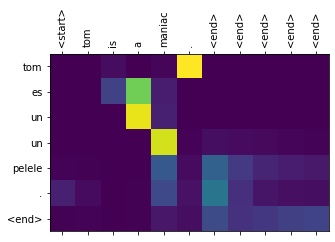

Expected: ¿ empiezo ?
Translation: ¿ puedo comenzar ?


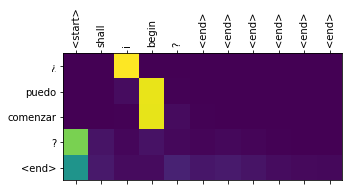

Expected: la primavera llego .
Translation: la primavera ha llegado .


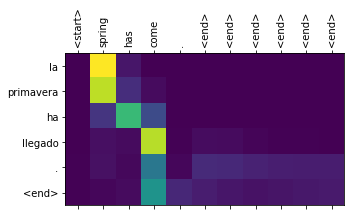

In [15]:
# Check translation for elements in test set
for batch in test_dataset:
    for source, target in zip(batch[0], batch[1]):
        # Prepares input
        source = tf.expand_dims(source,0)
        # Prints expected translation
        words = []
        for word in target.numpy():
            decoded = builder.target_tokenizer.index_to_word[word].decode()
            words.append(decoded)
            if decoded == '<end>':
                break
        print('Expected:', ' '.join(words[1:-1]))
        # Prints actual translation
        words = []
        prediction, attention = translator.translate(source, return_attention=True)
        for word in prediction:
            decoded = builder.target_tokenizer.index_to_word[word].decode()
            words.append(decoded)
        print('Translation:', ' '.join(words[:-1]))
        # Plots attention
        plot_attention(attention, tf.squeeze(source).numpy(), prediction, builder)